## Кузнецов Илья Александрович, 471 группа

# Задача 2. Сравнение методов классификации

## Задачи

[x] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
[x] Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блакнот с анализом этих данных можно найти [тут](https://github.com/rustam-azimov/ml-course/blob/main/practice/practice07_knn_nb/practice07_part02_classification_heart_disease_demo.ipynb).
[x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
[ ] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
[x] При необходимости выполнить полезные преобразования данных (например, трансформировать категориальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
[x] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
[x] Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).
[x] Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
[x] * (**+2 балла**) Реализовать еще один из методов классификации и добавить его в сравнение.
[x] * (**+2 балла**) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

In [193]:
%precision 4
import warnings
warnings.filterwarnings('ignore')

## Реализация метода K ближайших соседей (KNN)

In [194]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array

import numpy as np
np.set_printoptions(precision=4)

class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, num_neighbors=3):
        self._num_neighbors = num_neighbors

    def fit(self, X_train, y_train):
        X_train, y_train = check_X_y(X_train, y_train)
        self._X_train = X_train
        self._y_train = y_train
        return self

    def predict(self, X_test):
        X_test = check_array(X_test)
        predictions = []
        for test_row in X_test:
            neighbors_indexes = self._get_neighbors_indexes(test_row)
            label = self._most_popular_label(neighbors_indexes)
            predictions.append(label)
        return predictions

    def _get_neighbors_indexes(self, test_row):
        distances = list()
        for i, train_row in enumerate(self._X_train):
            dist = self._euclidean_distance(test_row, train_row)
            distances.append((i, dist))
        distances.sort(key=lambda tupl: tupl[1])
        neighbors_indexes = list()
        for i in range(self._num_neighbors):
            neighbors_indexes.append(distances[i][0])
        return neighbors_indexes

    def _most_popular_label(self, neighbors_indexes):
        labels = []
        for i in neighbors_indexes:
            labels.append(self._y_train[i])
        label = max(set(labels), key=labels.count)
        return label

    def _euclidean_distance(self, row1, row2):
        distance = 0.0
        for i in range(len(row1) - 1):
            distance += (row1[i] - row2[i]) ** 2
        return np.sqrt(distance)

    def get_params(self, deep=True):
        return {"num_neighbors": self._num_neighbors}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

## Реализация метода опорных векторов (SVM)

In [195]:
class SVMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha_value=1E-1, lamda_value=1E-1, num_iterations=100):
        self._alpha_value = alpha_value
        self._lamda_value = lamda_value
        self._num_iterations = num_iterations

    def fit(self, X_train, y_train):
        X_train, y_train = check_X_y(X_train, y_train)
        self._X_train = X_train
        self._y_train = y_train
        # for _ in range(self._num_iterations):
        #     self._update_weights()
        self._update_weights()
        return self

    def _update_weights(self):
        y_train_labels = np.where(self._y_train <= -1, 0, 1)
        self.w = np.zeros(self._X_train.shape[1])
        self.b = 0
        for i, train_row in enumerate(self._X_train):
            dw = 0; db = 0
            if y_train_labels[i] * (np.dot(train_row, self.w) - self.b) >= 1:
                dw = 2 * self._lamda_value * self.w
                db = 0
            else:
                dw = 2 * self._lamda_value * self.w - np.dot(train_row, y_train_labels[i])
                db = y_train_labels[i]
            self.w = self.w - self._alpha_value * dw
            self.b = self.b - self._alpha_value * db

    def predict(self, X_test):
        X_test = check_array(X_test)
        labels = np.sign(np.dot(X_test, self.w) - self.b)
        predictions = np.where(labels <= -1, 0, 1)
        return predictions

    def get_params(self, deep=True):
        return {"alpha_value": self._alpha_value,
                "num_iterations": self._num_iterations,
                "lamda_value": self._lamda_value}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

# Первый датасет

Этот набор данных содержит информацию о заболеваниях сердца у пациентов.

Признаки:
- **age** - возраст в годах,
- **sex** - (1 = мужчина; 0 = женщина),
- **cp** - тип боли в груди,
- **trestbps** - артериальное давление в состоянии покоя при поступлении в больницу (в мм рт. ст.),
- **chol** - холестерин в крови (в мг./дл.),
- **fbs** - (сахар в крови натощак > 120 мг/дл) (1 = истинно; 0 = ложно),
- **restecg** - результаты электрокардиографии в состоянии покоя,
- **thalach** - достигнутая максимальная частота сердечных сокращений,
- **exang** - стенокардия, вызванная физической нагрузкой (1 = да; 0 = нет),
- **oldpeak** - депрессия ST, вызванная физической нагрузкой по сравнению с покоем,
- **slope** - наклон сегмента ST пиковой физической нагрузки,
- **ca** - количество крупных сосудов (0 - 3), окрашенных при флоуроскопии,
- **thal** - (3 = норма; 6 = фиксированный дефект; 7 = обратимый дефект).

Целевой признак:
- **target** - есть болезнь или нет (1 = да; 0 = нет).

In [196]:
import pandas as pd
pd.set_option('display.precision', 4)

df = pd.read_csv('../data/heart_disease/heart.csv')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Пропущенных значений в данных нет, поэтому дополнительно их чистить или дополнять не требуется.
Выборка обладает категориальными признаками, некоторые из них в дальнейшем нужно будет преобразовать в количественные для решения задачи классификации.
В данных с виду не наблюдается явно лишних признаков.

## Разведочный анализ (EDA)

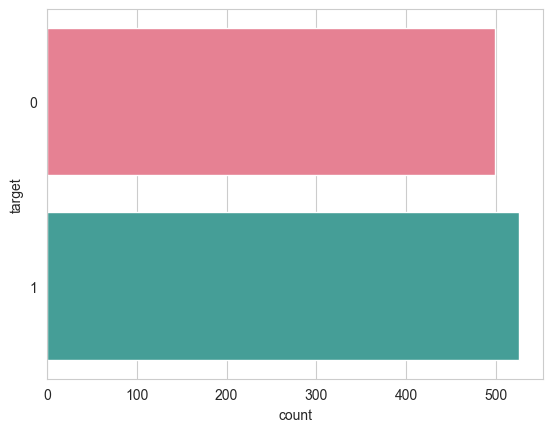

In [198]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.countplot(data=df, y="target", palette="husl")
plt.show()

In [199]:
df.target.value_counts()

1    526
0    499
Name: target, dtype: int64

Количество пациентов с заболеванием серца в выборке незначительно больше (на 27 человек), поэтому в целом данные сбалансированы.

In [200]:
# TODO

Изучим корреляционную карту данного датасета.

<AxesSubplot: >

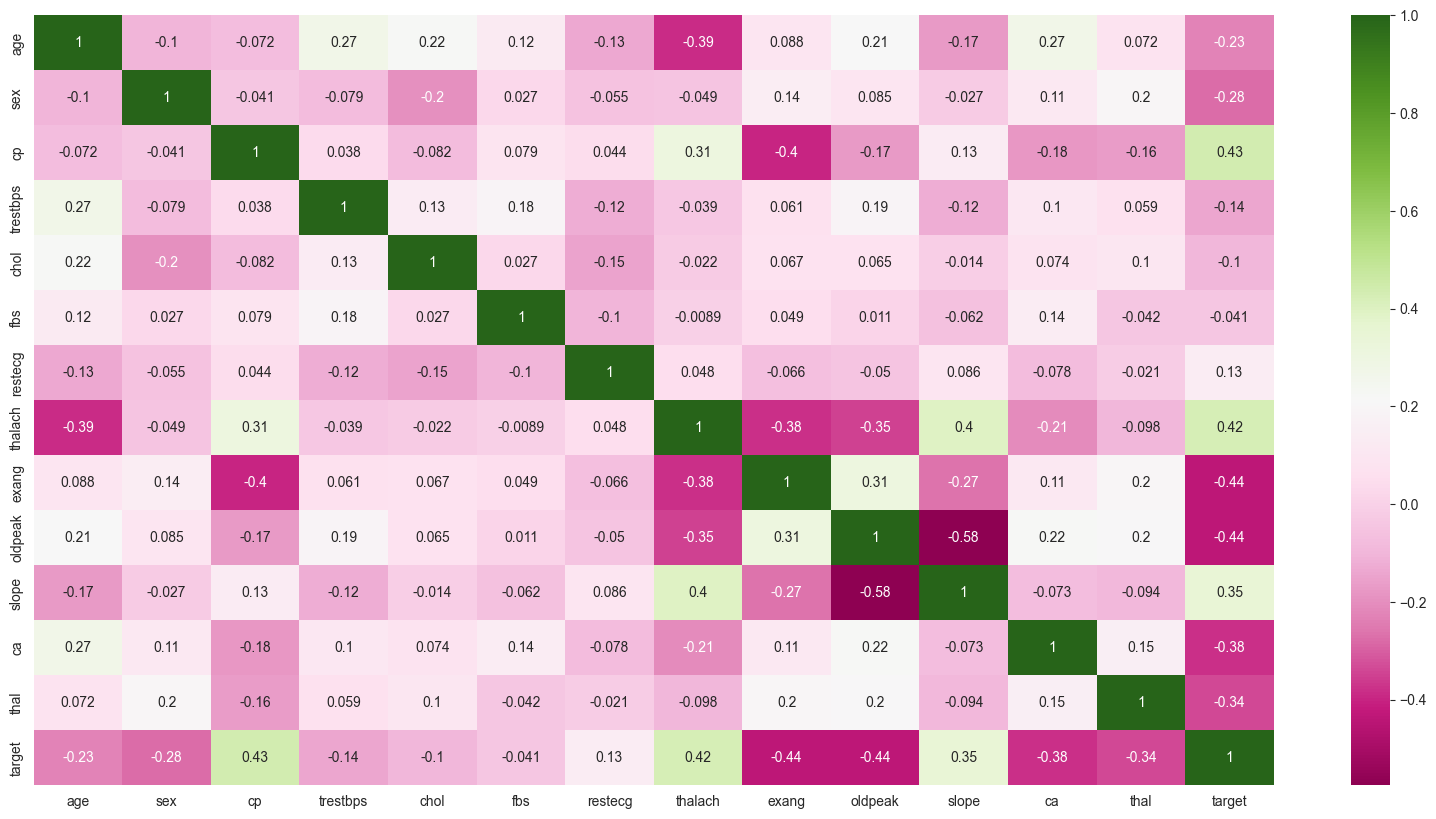

In [201]:
plt.figure(figsize = (20,10))
sns.heatmap(df.corr(), annot=True, cmap="PiYG")

Признаки **cp**, **thalach** и **slope** имеют наибольшую корреляцию с целевым признаком **target**.

## Преобразование признаков (Feature Engineering)

В датасете содержатся категориальные признаки **cp**, **slope**, и **thal**. Закодируем их.

In [202]:
cp_dum = pd.get_dummies(df['cp'], prefix = "cp")
thal_dum = pd.get_dummies(df['thal'], prefix = "thal")
slope_dum = pd.get_dummies(df['slope'], prefix = "slope")

frames = [df, cp_dum, thal_dum, slope_dum]
df = pd.concat(frames, axis = 1).drop(columns = ['cp', 'thal', 'slope'])
df

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,52,1,125,212,0,1,168,0,1.0,2,...,0,0,0,0,0,0,1,0,0,1
1,53,1,140,203,1,0,155,1,3.1,0,...,0,0,0,0,0,0,1,1,0,0
2,70,1,145,174,0,1,125,1,2.6,0,...,0,0,0,0,0,0,1,1,0,0
3,61,1,148,203,0,1,161,0,0.0,1,...,0,0,0,0,0,0,1,0,0,1
4,62,0,138,294,1,1,106,0,1.9,3,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,140,221,0,1,164,1,0.0,0,...,1,0,0,0,0,1,0,0,0,1
1021,60,1,125,258,0,0,141,1,2.8,1,...,0,0,0,0,0,0,1,0,1,0
1022,47,1,110,275,0,0,118,1,1.0,1,...,0,0,0,0,0,1,0,0,1,0
1023,50,0,110,254,0,0,159,0,0.0,0,...,0,0,0,0,0,1,0,0,0,1


## Разделение выборки на тренировочную и тестовую

In [203]:
from sklearn.model_selection import train_test_split

x = df.drop(['target'], axis=1)
y = df['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=19)

## Масштабирование признаков

In [204]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns=x.columns)
x_train_scaled

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,0.8519,-1.4361,-0.1025,0.3194,-0.4179,0.8964,-2.2568,-0.6940,0.0808,0.2107,...,-0.4464,1.5755,-0.2952,-0.0766,-0.2488,-1.0949,1.2489,-0.2864,1.0821,-0.9296
1,-1.2458,0.6963,-0.1025,1.3157,-0.4179,0.8964,0.5411,-0.6940,0.6591,0.2107,...,-0.4464,1.5755,-0.2952,-0.0766,-0.2488,0.9134,-0.8007,-0.2864,-0.9242,1.0757
2,-0.3626,0.6963,-2.1410,-0.3703,-0.4179,0.8964,0.1967,1.4409,-0.9105,0.2107,...,-0.4464,1.5755,-0.2952,-0.0766,-0.2488,-1.0949,1.2489,-0.2864,-0.9242,1.0757
3,0.7414,-1.4361,-0.1025,1.6031,-0.4179,-0.9784,0.8424,-0.6940,-0.9105,-0.7404,...,-0.4464,-0.6347,-0.2952,-0.0766,-0.2488,0.9134,-0.8007,-0.2864,-0.9242,1.0757
4,-1.3562,0.6963,-0.6688,-0.1212,2.3928,0.8964,1.9185,-0.6940,-0.2496,-0.7404,...,-0.4464,1.5755,-0.2952,-0.0766,-0.2488,-1.0949,1.2489,3.4917,-0.9242,-0.9296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,0.4102,0.6963,0.4637,-0.6768,2.3928,-0.9784,0.6702,-0.6940,-0.9105,-0.7404,...,-0.4464,1.5755,-0.2952,-0.0766,-0.2488,0.9134,-0.8007,-0.2864,-0.9242,1.0757
682,-1.2458,0.6963,-0.1025,1.3157,-0.4179,0.8964,0.5411,-0.6940,0.6591,0.2107,...,-0.4464,1.5755,-0.2952,-0.0766,-0.2488,0.9134,-0.8007,-0.2864,-0.9242,1.0757
683,0.2998,0.6963,-0.4423,0.2811,-0.4179,0.8964,-0.3629,-0.6940,-0.6627,-0.7404,...,2.2400,-0.6347,-0.2952,-0.0766,-0.2488,-1.0949,1.2489,-0.2864,-0.9242,1.0757
684,1.2935,0.6963,1.5962,-0.3511,-0.4179,-0.9784,-0.4920,-0.6940,0.9895,-0.7404,...,-0.4464,-0.6347,-0.2952,-0.0766,4.0187,-1.0949,-0.8007,-0.2864,-0.9242,1.0757


In [205]:
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x.columns)
x_test_scaled

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,0.6310,-1.4361,1.0300,-0.1212,-0.4179,0.8964,0.9285,-0.6940,-0.1670,-0.7404,...,-0.4464,-0.6347,3.3871,-0.0766,-0.2488,0.9134,-0.8007,-0.2864,-0.9242,1.0757
1,0.9623,-1.4361,0.1806,0.1087,-0.4179,-0.9784,0.9715,-0.6940,-0.9105,-0.7404,...,-0.4464,1.5755,-0.2952,-0.0766,-0.2488,0.9134,-0.8007,-0.2864,-0.9242,1.0757
2,0.2998,0.6963,-0.4423,0.2811,-0.4179,0.8964,-0.3629,-0.6940,-0.6627,-0.7404,...,2.2400,-0.6347,-0.2952,-0.0766,-0.2488,-1.0949,1.2489,-0.2864,-0.9242,1.0757
3,-1.7979,0.6963,0.3505,-1.3665,-0.4179,0.8964,1.0146,-0.6940,-0.9105,3.0641,...,-0.4464,1.5755,-0.2952,-0.0766,-0.2488,0.9134,-0.8007,-0.2864,-0.9242,1.0757
4,1.6247,-1.4361,0.4637,-0.1404,-0.4179,0.8964,0.0676,-0.6940,0.5765,1.1619,...,-0.4464,-0.6347,3.3871,-0.0766,-0.2488,0.9134,-0.8007,-0.2864,-0.9242,1.0757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,0.4102,0.6963,-0.2158,-0.5810,-0.4179,-0.9784,-0.7933,1.4409,0.9069,2.1130,...,-0.4464,-0.6347,-0.2952,-0.0766,-0.2488,-1.0949,1.2489,-0.2864,1.0821,-0.9296
335,-0.0314,0.6963,-0.6688,-1.1175,-0.4179,0.8964,-1.5681,-0.6940,0.2460,0.2107,...,-0.4464,-0.6347,-0.2952,-0.0766,-0.2488,-1.0949,1.2489,-0.2864,1.0821,-0.9296
336,-2.1291,0.6963,-0.6688,-0.9259,-0.4179,0.8964,-0.8364,1.4409,0.4112,-0.7404,...,-0.4464,-0.6347,-0.2952,-0.0766,-0.2488,-1.0949,1.2489,-0.2864,1.0821,-0.9296
337,-0.2522,0.6963,-0.2158,-0.8109,2.3928,0.8964,0.2828,1.4409,-0.0844,-0.7404,...,-0.4464,-0.6347,-0.2952,13.0576,-0.2488,-1.0949,-0.8007,-0.2864,1.0821,-0.9296


## Подбор оптимальных признаков (RFE)

In [206]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import RidgeClassifierCV

rfecv = RFECV(estimator=RidgeClassifierCV())

rfecv.fit(x_train_scaled, y_train)

selected_features = list(x_train_scaled.columns[rfecv.support_])
print("Optimal features: ", rfecv.n_features_)
print("Selected features: ", selected_features)

Optimal features:  11
Selected features:  ['sex', 'trestbps', 'thalach', 'exang', 'oldpeak', 'ca', 'cp_0', 'cp_2', 'thal_2', 'thal_3', 'slope_1']


Удалим признаки, не входящие в данный список.

In [207]:
x_train_scaled = x_train_scaled[selected_features]
x_train_scaled

,sex,trestbps,thalach,exang,oldpeak,ca,cp_0,cp_2,thal_2,thal_3,slope_1
0,-1.4361,-0.1025,-2.2568,-0.6940,0.0808,0.2107,-0.9350,1.5755,-1.0949,1.2489,1.0821
1,0.6963,-0.1025,0.5411,-0.6940,0.6591,0.2107,-0.9350,1.5755,0.9134,-0.8007,-0.9242
2,0.6963,-2.1410,0.1967,1.4409,-0.9105,0.2107,-0.9350,1.5755,-1.0949,1.2489,-0.9242
3,-1.4361,-0.1025,0.8424,-0.6940,-0.9105,-0.7404,1.0695,-0.6347,0.9134,-0.8007,-0.9242
4,0.6963,-0.6688,1.9185,-0.6940,-0.2496,-0.7404,-0.9350,1.5755,-1.0949,1.2489,-0.9242
...,...,...,...,...,...,...,...,...,...,...,...
681,0.6963,0.4637,0.6702,-0.6940,-0.9105,-0.7404,-0.9350,1.5755,0.9134,-0.8007,-0.9242
682,0.6963,-0.1025,0.5411,-0.6940,0.6591,0.2107,-0.9350,1.5755,0.9134,-0.8007,-0.9242
683,0.6963,-0.4423,-0.3629,-0.6940,-0.6627,-0.7404,-0.9350,-0.6347,-1.0949,1.2489,-0.9242
684,0.6963,1.5962,-0.4920,-0.6940,0.9895,-0.7404,1.0695,-0.6347,-1.0949,-0.8007,-0.9242


In [208]:
x_test_scaled = x_test_scaled[selected_features]
x_test_scaled

,sex,trestbps,thalach,exang,oldpeak,ca,cp_0,cp_2,thal_2,thal_3,slope_1
0,-1.4361,1.0300,0.9285,-0.6940,-0.1670,-0.7404,-0.9350,-0.6347,0.9134,-0.8007,-0.9242
1,-1.4361,0.1806,0.9715,-0.6940,-0.9105,-0.7404,-0.9350,1.5755,0.9134,-0.8007,-0.9242
2,0.6963,-0.4423,-0.3629,-0.6940,-0.6627,-0.7404,-0.9350,-0.6347,-1.0949,1.2489,-0.9242
3,0.6963,0.3505,1.0146,-0.6940,-0.9105,3.0641,-0.9350,1.5755,0.9134,-0.8007,-0.9242
4,-1.4361,0.4637,0.0676,-0.6940,0.5765,1.1619,-0.9350,-0.6347,0.9134,-0.8007,-0.9242
...,...,...,...,...,...,...,...,...,...,...,...
334,0.6963,-0.2158,-0.7933,1.4409,0.9069,2.1130,1.0695,-0.6347,-1.0949,1.2489,1.0821
335,0.6963,-0.6688,-1.5681,-0.6940,0.2460,0.2107,1.0695,-0.6347,-1.0949,1.2489,1.0821
336,0.6963,-0.6688,-0.8364,1.4409,0.4112,-0.7404,1.0695,-0.6347,-1.0949,1.2489,1.0821
337,0.6963,-0.2158,0.2828,1.4409,-0.0844,-0.7404,1.0695,-0.6347,-1.0949,-0.8007,1.0821


## Подбор оптимальных гиперпараметров и кросс-валидация

### Собственная реализация KNNClassifier

In [209]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

cv = StratifiedKFold(5, shuffle=True, random_state=19)

param_grid = [{"num_neighbors": [3, 5, 7, 9, 11, 13, 15]}]

searcher = GridSearchCV(KNNClassifier(), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_num_neighbors = searcher.best_params_["num_neighbors"]
print("Optimal num_neighbors =", optimal_num_neighbors)
print("Optimal score =", searcher.best_score_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ...................num_neighbors=3;, score=0.891 total time=   0.4s
[CV 2/5] END ...................num_neighbors=3;, score=0.927 total time=   0.4s
[CV 3/5] END ...................num_neighbors=3;, score=0.883 total time=   0.4s
[CV 4/5] END ...................num_neighbors=3;, score=0.891 total time=   0.5s
[CV 5/5] END ...................num_neighbors=3;, score=0.876 total time=   0.4s
[CV 1/5] END ...................num_neighbors=5;, score=0.891 total time=   0.4s
[CV 2/5] END ...................num_neighbors=5;, score=0.927 total time=   0.5s
[CV 3/5] END ...................num_neighbors=5;, score=0.883 total time=   0.4s
[CV 4/5] END ...................num_neighbors=5;, score=0.891 total time=   0.4s
[CV 5/5] END ...................num_neighbors=5;, score=0.876 total time=   0.4s
[CV 1/5] END ...................num_neighbors=7;, score=0.891 total time=   0.4s
[CV 2/5] END ...................num_neighbors=7;,

### Собственная реализация SVMClassifier

In [210]:
param_grid = [{"alpha_value": [1E-1, 1E-2, 1E-3],
               "lamda_value": [1E-1, 1E-2, 1E-3],
               "num_iterations": [100, 500, 1000]}]

searcher = GridSearchCV(SVMClassifier(), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_alpha_value = searcher.best_params_["alpha_value"]
print("Optimal alpha_value =", optimal_alpha_value)
optimal_lamda_value = searcher.best_params_["lamda_value"]
print("Optimal lamda_value =", optimal_lamda_value)
optimal_num_iterations = searcher.best_params_["num_iterations"]
print("Optimal num_iterations =", optimal_num_iterations)
print("Optimal score =", searcher.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END alpha_value=0.1, lamda_value=0.1, num_iterations=100;, score=0.514 total time=   0.0s
[CV 2/5] END alpha_value=0.1, lamda_value=0.1, num_iterations=100;, score=0.511 total time=   0.0s
[CV 3/5] END alpha_value=0.1, lamda_value=0.1, num_iterations=100;, score=0.511 total time=   0.0s
[CV 4/5] END alpha_value=0.1, lamda_value=0.1, num_iterations=100;, score=0.518 total time=   0.0s
[CV 5/5] END alpha_value=0.1, lamda_value=0.1, num_iterations=100;, score=0.518 total time=   0.0s
[CV 1/5] END alpha_value=0.1, lamda_value=0.1, num_iterations=500;, score=0.514 total time=   0.0s
[CV 2/5] END alpha_value=0.1, lamda_value=0.1, num_iterations=500;, score=0.511 total time=   0.0s
[CV 3/5] END alpha_value=0.1, lamda_value=0.1, num_iterations=500;, score=0.511 total time=   0.0s
[CV 4/5] END alpha_value=0.1, lamda_value=0.1, num_iterations=500;, score=0.518 total time=   0.0s
[CV 5/5] END alpha_value=0.1, lamda_value=0.1, 

### Библиотечная реализация LogisticRegression

In [211]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(LogisticRegression(random_state=19), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_logreg_c = searcher.best_params_["C"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...........................C=0.001;, score=0.884 total time=   0.0s
[CV 2/5] END ...........................C=0.001;, score=0.847 total time=   0.0s
[CV 3/5] END ...........................C=0.001;, score=0.869 total time=   0.0s
[CV 4/5] END ...........................C=0.001;, score=0.825 total time=   0.0s
[CV 5/5] END ...........................C=0.001;, score=0.796 total time=   0.0s
[CV 1/5] END .............................C=0.1;, score=0.920 total time=   0.0s
[CV 2/5] END .............................C=0.1;, score=0.876 total time=   0.0s
[CV 3/5] END .............................C=0.1;, score=0.883 total time=   0.0s
[CV 4/5] END .............................C=0.1;, score=0.869 total time=   0.0s
[CV 5/5] END .............................C=0.1;, score=0.818 total time=   0.0s
[CV 1/5] END ...............................C=1;, score=0.877 total time=   0.0s
[CV 2/5] END ...............................C=1;,

### Библиотечная реализация SVM

In [212]:
from sklearn.svm import SVC

param_grid = {"kernel": ["linear", "rbf"],
              "C": [0.1, 0.25, 0.5, 0.75, 1, 2],
              "gamma": ["scale", "auto", 1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(SVC(random_state=19), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_kernel = searcher.best_params_["kernel"]
optimal_svm_c = searcher.best_params_["C"]
optimal_gamma = searcher.best_params_["gamma"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.906 total time=   0.0s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.861 total time=   0.0s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.883 total time=   0.0s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.869 total time=   0.0s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.825 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.891 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.869 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.883 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.876 total time=   0.0s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.825 total time=   0.0s
[CV 1/5] END ..C=0.1, gamma=auto, kernel=linear;, score=0.906 total time=   0.0s
[CV 2/5] END ..C=0.1, gamma=auto, kernel=linear

### Библиотечная реализация KNN

In [213]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = [{"n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
               "weights": ['distance', 'uniform']}]

searcher = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_n_neighbors = searcher.best_params_["n_neighbors"]
optimal_weights = searcher.best_params_["weights"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...n_neighbors=1, weights=distance;, score=0.971 total time=   0.0s
[CV 2/5] END ...n_neighbors=1, weights=distance;, score=0.985 total time=   0.0s
[CV 3/5] END ...n_neighbors=1, weights=distance;, score=0.964 total time=   0.0s
[CV 4/5] END ...n_neighbors=1, weights=distance;, score=0.985 total time=   0.0s
[CV 5/5] END ...n_neighbors=1, weights=distance;, score=0.956 total time=   0.0s
[CV 1/5] END ....n_neighbors=1, weights=uniform;, score=0.971 total time=   0.0s
[CV 2/5] END ....n_neighbors=1, weights=uniform;, score=0.985 total time=   0.0s
[CV 3/5] END ....n_neighbors=1, weights=uniform;, score=0.964 total time=   0.0s
[CV 4/5] END ....n_neighbors=1, weights=uniform;, score=0.985 total time=   0.0s
[CV 5/5] END ....n_neighbors=1, weights=uniform;, score=0.956 total time=   0.0s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.942 total time=   0.0s
[CV 2/5] END ...n_neighbors=3, weights=distance

### Библиотечная реализация Naive Bayes

In [214]:
from sklearn.naive_bayes import GaussianNB

param_grid = [{"priors": [[0.5, 0.5], [0.33, 0.67], [0.67, 0.33], [0.25, 0.75], [0.75, 0.25]],
               "var_smoothing": np.logspace(0, -10, num=100)}]

searcher = GridSearchCV(GaussianNB(), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_priors = searcher.best_params_["priors"]
optimal_var_smoothing = searcher.best_params_["var_smoothing"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV 1/5] END priors=[0.5, 0.5], var_smoothing=1.0;, score=0.884 total time=   0.0s
[CV 2/5] END priors=[0.5, 0.5], var_smoothing=1.0;, score=0.861 total time=   0.0s
[CV 3/5] END priors=[0.5, 0.5], var_smoothing=1.0;, score=0.861 total time=   0.0s
[CV 4/5] END priors=[0.5, 0.5], var_smoothing=1.0;, score=0.839 total time=   0.0s
[CV 5/5] END priors=[0.5, 0.5], var_smoothing=1.0;, score=0.803 total time=   0.0s
[CV 1/5] END priors=[0.5, 0.5], var_smoothing=0.7924828983539173;, score=0.891 total time=   0.0s
[CV 2/5] END priors=[0.5, 0.5], var_smoothing=0.7924828983539173;, score=0.861 total time=   0.0s
[CV 3/5] END priors=[0.5, 0.5], var_smoothing=0.7924828983539173;, score=0.861 total time=   0.0s
[CV 4/5] END priors=[0.5, 0.5], var_smoothing=0.7924828983539173;, score=0.839 total time=   0.0s
[CV 5/5] END priors=[0.5, 0.5], var_smoothing=0.7924828983539173;, score=0.803 total time=   0.0s
[CV 1/5] END priors=[0.5, 0.5],

### Библиотечная реализация Decision Tree

In [215]:
from sklearn.tree import DecisionTreeClassifier

param_grid = [{"criterion": ["gini", "entropy", "log_loss"],
               "splitter": ["best", "random"],
               "max_depth": [10, 20, 30],
               "min_samples_split": [2, 5, 10],
               "min_samples_leaf": [2, 5, 10],
               "max_features": [2, 5, 10]}]

searcher = GridSearchCV(DecisionTreeClassifier(random_state=19), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_criterion = searcher.best_params_["criterion"]
optimal_splitter = searcher.best_params_["splitter"]
optimal_max_depth = searcher.best_params_["max_depth"]
optimal_min_samples_split = searcher.best_params_["min_samples_split"]
optimal_min_samples_leaf = searcher.best_params_["min_samples_leaf"]
optimal_max_features = searcher.best_params_["max_features"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
[CV 1/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.884 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.876 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.891 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.920 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.810 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.891 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_featu

## Тестирование обученных моделей

In [216]:
scores = {}

### Собственная реализация KNNClassifier

In [217]:
from sklearn.metrics import accuracy_score

own_knn = KNNClassifier(num_neighbors=optimal_num_neighbors)

own_knn = own_knn.fit(x_train_scaled, y_train)

own_knn_y_test_pred = own_knn.predict(x_test_scaled)
own_knn_score = accuracy_score(y_test, own_knn_y_test_pred)

scores['OWN_KNN'] = own_knn_score
print("OWN_KNN score =", own_knn_score)

OWN_KNN score = 0.8997050147492626


### Собственная реализация SVMClassifier

In [218]:
own_svm = SVMClassifier(alpha_value=optimal_alpha_value,
                           lamda_value=optimal_lamda_value,
                           num_iterations=optimal_num_iterations)

own_svm = own_svm.fit(x_train_scaled, y_train)

own_svm_y_test_pred = own_svm.predict(x_test_scaled)
own_svm_score = accuracy_score(y_test, own_svm_y_test_pred)

scores['OWN_SVM'] = own_svm_score
print("OWN_SVM score =", own_svm_score)

OWN_SVM score = 0.5103244837758112


### Библиотечная реализация LogisticRegression

In [219]:
lib_logreg = LogisticRegression(C=optimal_logreg_c, random_state=19)

lib_logreg = lib_logreg.fit(x_train_scaled, y_train)

lib_logreg_y_test_pred = lib_logreg.predict(x_test_scaled)
lib_logreg_score = accuracy_score(y_test, lib_logreg_y_test_pred)

scores['LIB_LOGREG'] = lib_logreg_score
print("LIB_LOGREG score =", lib_logreg_score)

LIB_LOGREG score = 0.855457227138643


### Библиотечная реализация SVM

In [220]:
lib_svm = SVC(kernel=optimal_kernel, C=optimal_svm_c, gamma=optimal_gamma, random_state=19)

lib_svm = lib_svm.fit(x_train_scaled, y_train)

lib_svm_y_test_pred = lib_svm.predict(x_test_scaled)
lib_svm_score = accuracy_score(y_test, lib_svm_y_test_pred)

scores['LIB_SVM'] = lib_svm_score
print("LIB_SVM score =", lib_svm_score)

LIB_SVM score = 0.9351032448377581


### Библиотечная реализация KNN

In [221]:
lib_knn = KNeighborsClassifier(n_neighbors=optimal_n_neighbors)

lib_knn = lib_knn.fit(x_train_scaled, y_train)

lib_knn_y_test_pred = lib_knn.predict(x_test_scaled)
lib_knn_score = accuracy_score(y_test, lib_knn_y_test_pred)

scores['LIB_KNN'] = lib_knn_score
print("LIB_KNN score =", lib_knn_score)

LIB_KNN score = 0.8466076696165191


### Библиотечная реализация Naive Bayes

In [222]:
lib_nb = GaussianNB(priors=optimal_priors, var_smoothing=optimal_var_smoothing)

lib_nb = lib_nb.fit(x_train_scaled, y_train)

lib_nb_y_test_pred = lib_nb.predict(x_test_scaled)
lib_nb_score = accuracy_score(y_test, lib_nb_y_test_pred)

scores['LIB_NB'] = lib_nb_score
print("LIB_NB score =", lib_nb_score)

LIB_NB score = 0.8436578171091446


### Библиотечная реализация Decision Tree

In [223]:
lib_dt = DecisionTreeClassifier(criterion=optimal_criterion, max_depth=optimal_max_depth,
                                    max_features=optimal_max_features, min_samples_leaf=optimal_min_samples_leaf,
                                    min_samples_split=optimal_min_samples_split, splitter=optimal_splitter, random_state=19)

lib_dt = lib_dt.fit(x_train_scaled, y_train)

lib_dt_y_test_pred = lib_dt.predict(x_test_scaled)
lib_dt_score = accuracy_score(y_test, lib_dt_y_test_pred)

scores['LIB_DT'] = lib_dt_score
print("LIB_DT score =", lib_dt_score)

LIB_DT score = 0.9469026548672567


## Сравнение обученных моделей

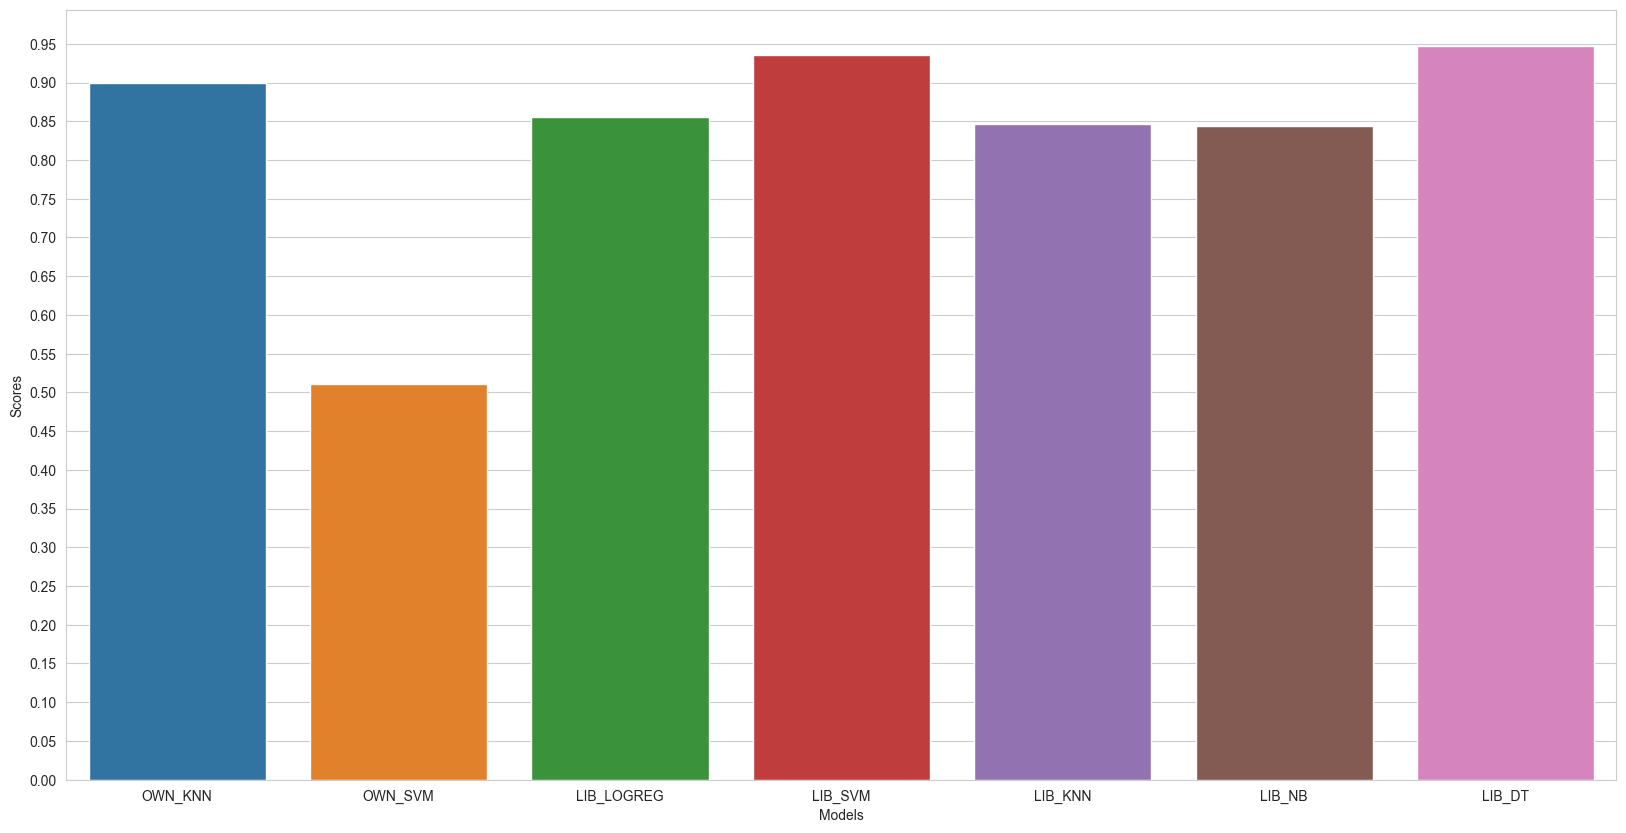

In [224]:
sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
plt.xlabel("Models")
plt.ylabel("Scores")
plt.yticks(np.arange(0, 1.05, 0.05))

sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.show()

### Построение Confusion Matrix для моделей

In [225]:
from sklearn.metrics import confusion_matrix

own_knn_cm = confusion_matrix(y_test, own_knn_y_test_pred)
own_svm_cm = confusion_matrix(y_test, own_svm_y_test_pred)
lib_logreg_cm = confusion_matrix(y_test, lib_logreg_y_test_pred)
lib_knn_cm = confusion_matrix(y_test, lib_knn_y_test_pred)
lib_svm_cm = confusion_matrix(y_test, lib_svm_y_test_pred)
lib_nb_cm = confusion_matrix(y_test, lib_nb_y_test_pred)
lib_dt_cm = confusion_matrix(y_test, lib_dt_y_test_pred)

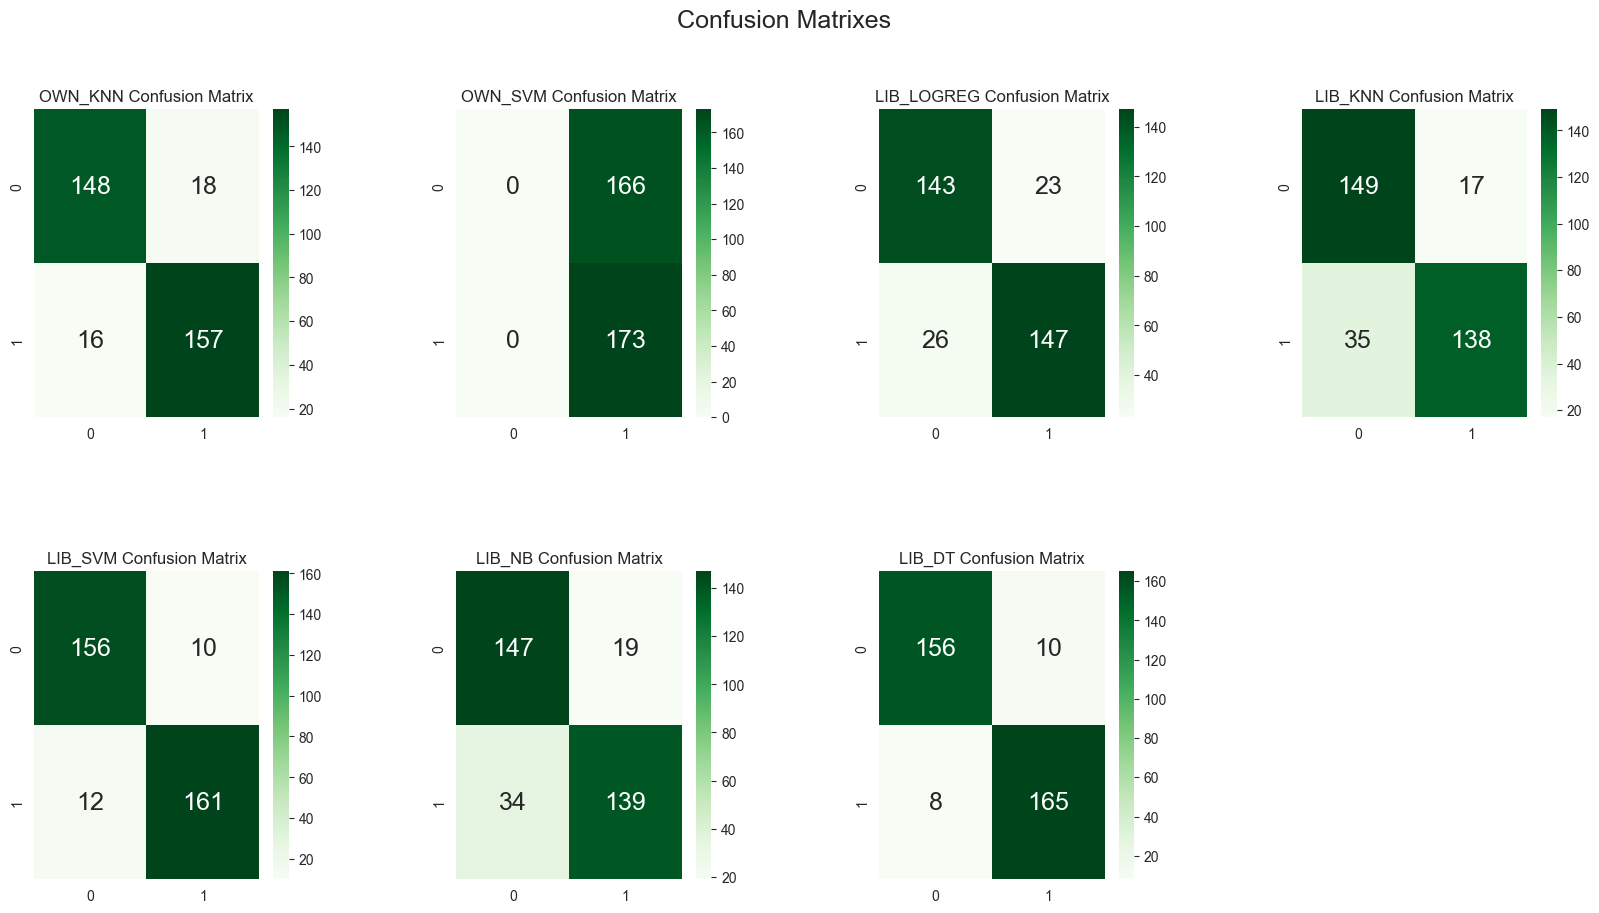

In [226]:
plt.figure(figsize=(20, 10))
plt.suptitle("Confusion Matrixes", fontsize=18)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.subplot(2, 4, 1)
plt.title("OWN_KNN Confusion Matrix")
sns.heatmap(own_knn_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 2)
plt.title("OWN_SVM Confusion Matrix")
sns.heatmap(own_svm_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 3)
plt.title("LIB_LOGREG Confusion Matrix")
sns.heatmap(lib_logreg_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 4)
plt.title("LIB_KNN Confusion Matrix")
sns.heatmap(lib_knn_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 5)
plt.title("LIB_SVM Confusion Matrix")
sns.heatmap(lib_svm_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 6)
plt.title("LIB_NB Confusion Matrix")
sns.heatmap(lib_nb_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 7)
plt.title("LIB_DT Confusion Matrix")
sns.heatmap(lib_dt_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})
plt.show()

## Выводы об обученных моделях первого датасета

# Второй датасет

В качестве второго набора данных рассмотрим встроенный в **sklearn** небольшой датасет с информацией о разновидностях ириса.

Признаки:
- **sepal length (cm)** - длина чашелистика,
- **sepal width (cm)** - ширина чашелистика,
- **petal length (cm)** - длина лепестка,
- **petal width (cm)** - ширина лепестка.

Целевой признак:
- **target** - вид ириса.

In [227]:
from sklearn.datasets import load_iris

iris = load_iris()

df = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                     columns=iris['feature_names'] + ['target'])
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    float64
dtypes: float64(5)
memory usage: 6.0 KB


Пропущенных значений в данных нет, поэтому дополнительно их чистить или дополнять не требуется.
Выборка обладает количественными признаками для решения задачи классификации.
В данных с виду не наблюдается явно лишних признаков.

## Разведочный анализ (EDA)

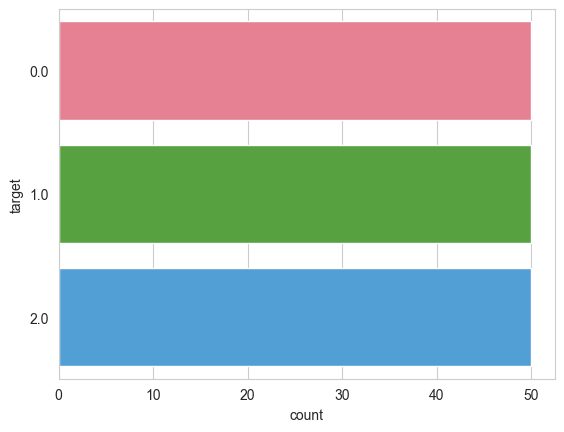

In [229]:
sns.countplot(data=df, y="target", palette="husl")
plt.show()

In [230]:
df.target.value_counts()

0.0    50
1.0    50
2.0    50
Name: target, dtype: int64

Датасет сбалансирован: всего имеется 3 вида ириса, при этом на каждый из них проходится ровно по 50 значений в данных.

In [231]:
# TODO

Изучим корреляционную карту данного датасета.

<AxesSubplot: >

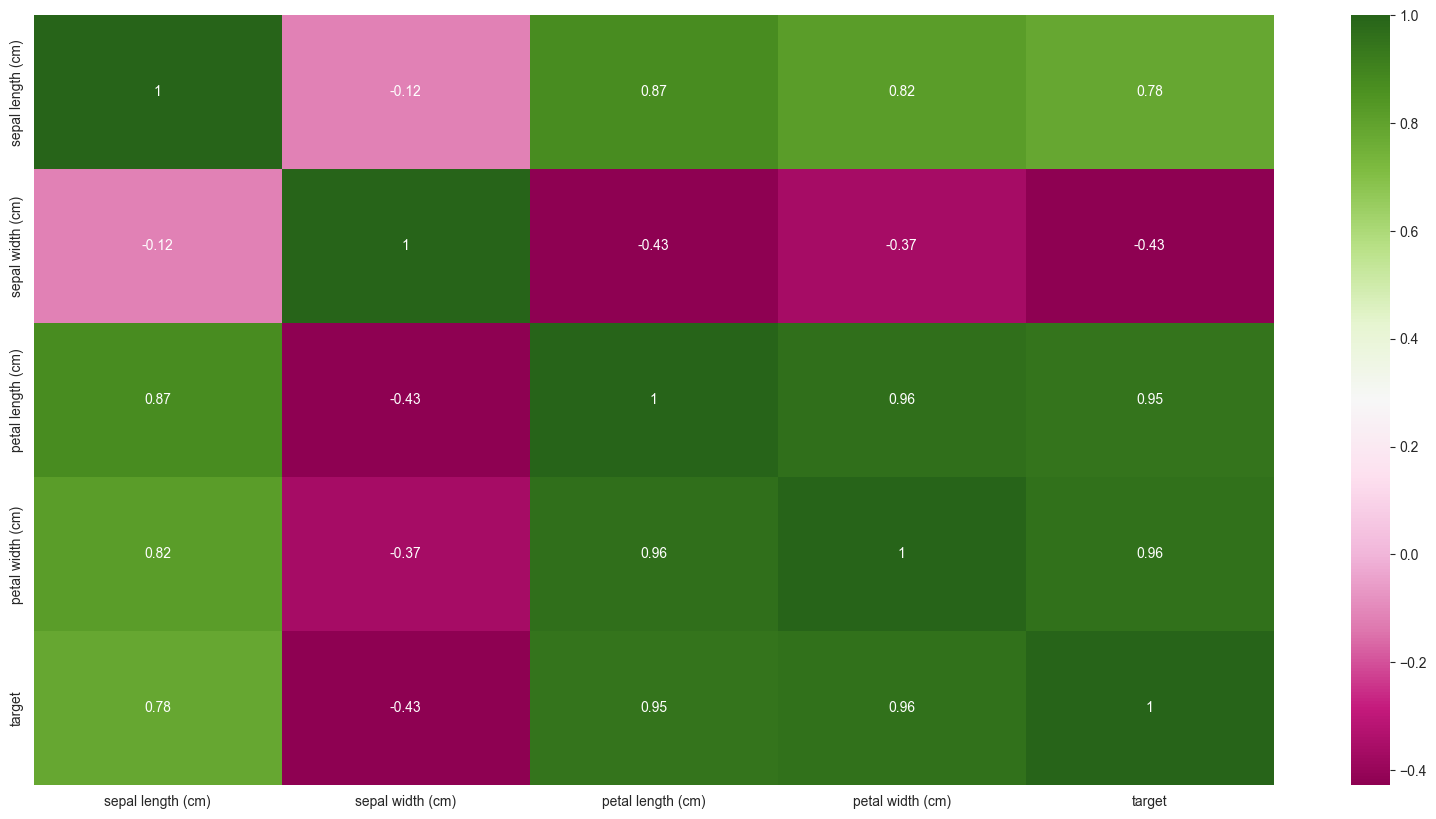

In [232]:
plt.figure(figsize = (20,10))
sns.heatmap(df.corr(), annot=True, cmap="PiYG")

**sepal width (cm)** имеет отрицательную корреляцию с **target**. Другие признаки имеют большую корреляцию с целевым признаком. При этом у данных признаков также наблюдается сильная корреляция между собой.

## Преобразование признаков (Feature Engineering)

В датасете содержится категориальный признак **target**, однако он уже закодирован и подлежит дальнейшему анализу.

## Разделение выборки на тренировочную и тестовую

In [233]:
x = df.drop(['target'], axis=1)
y = df['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=19)

## Масштабирование признаков

In [234]:
scaler = StandardScaler()

x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns=x.columns)
x_train_scaled

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-1.0698,0.9580,-1.3963,-1.1943
1,0.0132,-0.1457,0.2358,0.3928
2,0.1336,-0.3664,0.4047,0.3928
3,-1.7918,-0.1457,-1.3963,-1.3265
4,-1.9121,-0.1457,-1.5089,-1.4588
...,...,...,...,...
95,1.2166,0.0750,0.6298,0.3928
96,-0.9494,1.6202,-1.2838,-1.1943
97,-0.9494,-1.2493,-0.4396,-0.1362
98,0.7352,0.2958,0.7424,1.0541


In [235]:
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x.columns)
x_test_scaled

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-1.4308,0.2958,-1.3963,-1.3265
1,1.0963,-0.1457,0.9675,1.1863
2,-0.4681,-1.0286,0.3484,-0.0040
3,-0.3478,-0.1457,0.1795,0.1283
4,-0.8291,0.9580,-1.2838,-1.3265
5,-1.0698,0.7372,-1.2838,-1.3265
6,-1.7918,-0.3664,-1.3401,-1.3265
7,-1.1901,1.1787,-1.3401,-1.4588
8,-0.3478,-0.8079,0.2358,0.1283
9,2.0589,-0.1457,1.5866,1.1863


## Подбор оптимальных признаков (RFE)

In [236]:
rfecv = RFECV(estimator=RidgeClassifierCV())

rfecv.fit(x_train_scaled, y_train)

selected_features = list(x_train_scaled.columns[rfecv.support_])
print("Optimal features: ", rfecv.n_features_)
print("Selected features: ", selected_features)

Optimal features:  3
Selected features:  ['sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


Удалим признаки, не входящие в данный список.

In [237]:
x_train_scaled = x_train_scaled[selected_features]
x_train_scaled

,sepal width (cm),petal length (cm),petal width (cm)
0,0.9580,-1.3963,-1.1943
1,-0.1457,0.2358,0.3928
2,-0.3664,0.4047,0.3928
3,-0.1457,-1.3963,-1.3265
4,-0.1457,-1.5089,-1.4588
...,...,...,...
95,0.0750,0.6298,0.3928
96,1.6202,-1.2838,-1.1943
97,-1.2493,-0.4396,-0.1362
98,0.2958,0.7424,1.0541


In [238]:
x_test_scaled = x_test_scaled[selected_features]
x_test_scaled

,sepal width (cm),petal length (cm),petal width (cm)
0,0.2958,-1.3963,-1.3265
1,-0.1457,0.9675,1.1863
2,-1.0286,0.3484,-0.0040
3,-0.1457,0.1795,0.1283
4,0.9580,-1.2838,-1.3265
5,0.7372,-1.2838,-1.3265
6,-0.3664,-1.3401,-1.3265
7,1.1787,-1.3401,-1.4588
8,-0.8079,0.2358,0.1283
9,-0.1457,1.5866,1.1863


## Подбор оптимальных гиперпараметров и кросс-валидация

### Собственная реализация KNNClassifier

In [239]:
cv = StratifiedKFold(5, shuffle=True, random_state=19)

param_grid = [{"num_neighbors": [3, 5, 7, 9, 11, 13, 15]}]

searcher = GridSearchCV(KNNClassifier(), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_num_neighbors = searcher.best_params_["num_neighbors"]
print("Optimal num_neighbors =", optimal_num_neighbors)
print("Optimal score =", searcher.best_score_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ...................num_neighbors=3;, score=0.950 total time=   0.0s
[CV 2/5] END ...................num_neighbors=3;, score=1.000 total time=   0.0s
[CV 3/5] END ...................num_neighbors=3;, score=0.900 total time=   0.0s
[CV 4/5] END ...................num_neighbors=3;, score=0.950 total time=   0.0s
[CV 5/5] END ...................num_neighbors=3;, score=0.900 total time=   0.0s
[CV 1/5] END ...................num_neighbors=5;, score=0.950 total time=   0.0s
[CV 2/5] END ...................num_neighbors=5;, score=1.000 total time=   0.0s
[CV 3/5] END ...................num_neighbors=5;, score=0.900 total time=   0.0s
[CV 4/5] END ...................num_neighbors=5;, score=0.950 total time=   0.0s
[CV 5/5] END ...................num_neighbors=5;, score=0.900 total time=   0.0s
[CV 1/5] END ...................num_neighbors=7;, score=0.950 total time=   0.0s
[CV 2/5] END ...................num_neighbors=7;,

### Собственная реализация SVMClassifier

In [240]:
param_grid = [{"alpha_value": [1E-1, 1E-2, 1E-3],
               "lamda_value": [1E-1, 1E-2, 1E-3],
               "num_iterations": [100, 500, 1000]}]

searcher = GridSearchCV(SVMClassifier(), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_alpha_value = searcher.best_params_["alpha_value"]
print("Optimal alpha_value =", optimal_alpha_value)
optimal_lamda_value = searcher.best_params_["lamda_value"]
print("Optimal lamda_value =", optimal_lamda_value)
optimal_num_iterations = searcher.best_params_["num_iterations"]
print("Optimal num_iterations =", optimal_num_iterations)
print("Optimal score =", searcher.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END alpha_value=0.1, lamda_value=0.1, num_iterations=100;, score=0.350 total time=   0.0s
[CV 2/5] END alpha_value=0.1, lamda_value=0.1, num_iterations=100;, score=0.350 total time=   0.0s
[CV 3/5] END alpha_value=0.1, lamda_value=0.1, num_iterations=100;, score=0.300 total time=   0.0s
[CV 4/5] END alpha_value=0.1, lamda_value=0.1, num_iterations=100;, score=0.350 total time=   0.0s
[CV 5/5] END alpha_value=0.1, lamda_value=0.1, num_iterations=100;, score=0.350 total time=   0.0s
[CV 1/5] END alpha_value=0.1, lamda_value=0.1, num_iterations=500;, score=0.350 total time=   0.0s
[CV 2/5] END alpha_value=0.1, lamda_value=0.1, num_iterations=500;, score=0.350 total time=   0.0s
[CV 3/5] END alpha_value=0.1, lamda_value=0.1, num_iterations=500;, score=0.300 total time=   0.0s
[CV 4/5] END alpha_value=0.1, lamda_value=0.1, num_iterations=500;, score=0.350 total time=   0.0s
[CV 5/5] END alpha_value=0.1, lamda_value=0.1, 

### Библиотечная реализация LogisticRegression

In [241]:
param_grid = {'C': [1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(LogisticRegression(random_state=19), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_logreg_c = searcher.best_params_["C"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...........................C=0.001;, score=0.700 total time=   0.0s
[CV 2/5] END ...........................C=0.001;, score=0.900 total time=   0.0s
[CV 3/5] END ...........................C=0.001;, score=0.650 total time=   0.0s
[CV 4/5] END ...........................C=0.001;, score=0.750 total time=   0.0s
[CV 5/5] END ...........................C=0.001;, score=0.850 total time=   0.0s
[CV 1/5] END .............................C=0.1;, score=0.900 total time=   0.0s
[CV 2/5] END .............................C=0.1;, score=0.900 total time=   0.0s
[CV 3/5] END .............................C=0.1;, score=0.900 total time=   0.0s
[CV 4/5] END .............................C=0.1;, score=0.900 total time=   0.0s
[CV 5/5] END .............................C=0.1;, score=0.850 total time=   0.0s
[CV 1/5] END ...............................C=1;, score=0.950 total time=   0.0s
[CV 2/5] END ...............................C=1;,

### Библиотечная реализация SVM

In [242]:
param_grid = {"kernel": ["linear", "rbf"],
              "C": [0.1, 0.25, 0.5, 0.75, 1, 2],
              "gamma": ["scale", "auto", 1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(SVC(random_state=19), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_kernel = searcher.best_params_["kernel"]
optimal_svm_c = searcher.best_params_["C"]
optimal_gamma = searcher.best_params_["gamma"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=1.000 total time=   0.0s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=1.000 total time=   0.0s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=1.000 total time=   0.0s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.950 total time=   0.0s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=1.000 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.950 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.950 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=1.000 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.900 total time=   0.0s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.950 total time=   0.0s
[CV 1/5] END ..C=0.1, gamma=auto, kernel=linear;, score=1.000 total time=   0.0s
[CV 2/5] END ..C=0.1, gamma=auto, kernel=linear

### Библиотечная реализация KNN

In [243]:
param_grid = [{"n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
               "weights": ['distance', 'uniform']}]

searcher = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_n_neighbors = searcher.best_params_["n_neighbors"]
optimal_weights = searcher.best_params_["weights"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...n_neighbors=1, weights=distance;, score=0.950 total time=   0.0s
[CV 2/5] END ...n_neighbors=1, weights=distance;, score=0.950 total time=   0.0s
[CV 3/5] END ...n_neighbors=1, weights=distance;, score=0.950 total time=   0.0s
[CV 4/5] END ...n_neighbors=1, weights=distance;, score=0.900 total time=   0.0s
[CV 5/5] END ...n_neighbors=1, weights=distance;, score=1.000 total time=   0.0s
[CV 1/5] END ....n_neighbors=1, weights=uniform;, score=0.950 total time=   0.0s
[CV 2/5] END ....n_neighbors=1, weights=uniform;, score=0.950 total time=   0.0s
[CV 3/5] END ....n_neighbors=1, weights=uniform;, score=0.950 total time=   0.0s
[CV 4/5] END ....n_neighbors=1, weights=uniform;, score=0.900 total time=   0.0s
[CV 5/5] END ....n_neighbors=1, weights=uniform;, score=1.000 total time=   0.0s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.950 total time=   0.0s
[CV 2/5] END ...n_neighbors=3, weights=distance

### Библиотечная реализация Naive Bayes

In [244]:
param_grid = [{"priors": [[0.5, 0.3, 0.2], [0.3, 0.3, 0.4], [0.4, 0.3, 0.3], [0.3, 0.4, 0.3], [0.2, 0.3, 0.5]],
               "var_smoothing": np.logspace(0, -10, num=100)}]

searcher = GridSearchCV(GaussianNB(), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_priors = searcher.best_params_["priors"]
optimal_var_smoothing = searcher.best_params_["var_smoothing"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV 1/5] END priors=[0.5, 0.3, 0.2], var_smoothing=1.0;, score=0.900 total time=   0.0s
[CV 2/5] END priors=[0.5, 0.3, 0.2], var_smoothing=1.0;, score=0.950 total time=   0.0s
[CV 3/5] END priors=[0.5, 0.3, 0.2], var_smoothing=1.0;, score=0.950 total time=   0.0s
[CV 4/5] END priors=[0.5, 0.3, 0.2], var_smoothing=1.0;, score=0.750 total time=   0.0s
[CV 5/5] END priors=[0.5, 0.3, 0.2], var_smoothing=1.0;, score=0.850 total time=   0.0s
[CV 1/5] END priors=[0.5, 0.3, 0.2], var_smoothing=0.7924828983539173;, score=0.900 total time=   0.0s
[CV 2/5] END priors=[0.5, 0.3, 0.2], var_smoothing=0.7924828983539173;, score=1.000 total time=   0.0s
[CV 3/5] END priors=[0.5, 0.3, 0.2], var_smoothing=0.7924828983539173;, score=0.950 total time=   0.0s
[CV 4/5] END priors=[0.5, 0.3, 0.2], var_smoothing=0.7924828983539173;, score=0.800 total time=   0.0s
[CV 5/5] END priors=[0.5, 0.3, 0.2], var_smoothing=0.7924828983539173;, score=0.850 

### Библиотечная реализация Decision Tree

In [245]:
param_grid = [{"criterion": ["gini", "entropy", "log_loss"],
               "splitter": ["best", "random"],
               "max_depth": [10, 20, 30],
               "min_samples_split": [2, 5, 10],
               "min_samples_leaf": [2, 5, 10],
               "max_features": [2, 5, 10]}]

searcher = GridSearchCV(DecisionTreeClassifier(random_state=19), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_criterion = searcher.best_params_["criterion"]
optimal_splitter = searcher.best_params_["splitter"]
optimal_max_depth = searcher.best_params_["max_depth"]
optimal_min_samples_split = searcher.best_params_["min_samples_split"]
optimal_min_samples_leaf = searcher.best_params_["min_samples_leaf"]
optimal_max_features = searcher.best_params_["max_features"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
[CV 1/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=1.000 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.950 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.900 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.800 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=1.000 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=1.000 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_featu

## Тестирование обученных моделей

In [246]:
scores = {}

### Собственная реализация KNNClassifier

In [247]:
own_knn = KNNClassifier(num_neighbors=optimal_num_neighbors)

own_knn = own_knn.fit(x_train_scaled, y_train)

own_knn_y_test_pred = own_knn.predict(x_test_scaled)
own_knn_score = accuracy_score(y_test, own_knn_y_test_pred)

scores['OWN_KNN'] = own_knn_score
print("OWN_KNN score =", own_knn_score)

OWN_KNN score = 0.94


### Собственная реализация SVMClassifier

In [248]:
own_svm = SVMClassifier(alpha_value=optimal_alpha_value,
                        lamda_value=optimal_lamda_value,
                        num_iterations=optimal_num_iterations)

own_svm = own_svm.fit(x_train_scaled, y_train)

own_svm_y_test_pred = own_svm.predict(x_test_scaled)
own_svm_score = accuracy_score(y_test, own_svm_y_test_pred)

scores['OWN_SVM'] = own_svm_score
print("OWN_SVM score =", own_svm_score)

OWN_SVM score = 0.32


### Библиотечная реализация LogisticRegression

In [249]:
lib_logreg = LogisticRegression(C=optimal_logreg_c, random_state=19)

lib_logreg = lib_logreg.fit(x_train_scaled, y_train)

lib_logreg_y_test_pred = lib_logreg.predict(x_test_scaled)
lib_logreg_score = accuracy_score(y_test, lib_logreg_y_test_pred)

scores['LIB_LOGREG'] = lib_logreg_score
print("LIB_LOGREG score =", lib_logreg_score)

LIB_LOGREG score = 0.94


### Библиотечная реализация SVM

In [250]:
lib_svm = SVC(kernel=optimal_kernel, C=optimal_svm_c, gamma=optimal_gamma, random_state=19)

lib_svm = lib_svm.fit(x_train_scaled, y_train)

lib_svm_y_test_pred = lib_svm.predict(x_test_scaled)
lib_svm_score = accuracy_score(y_test, lib_svm_y_test_pred)

scores['LIB_SVM'] = lib_svm_score
print("LIB_SVM score =", lib_svm_score)

LIB_SVM score = 0.94


### Библиотечная реализация KNN

In [251]:
lib_knn = KNeighborsClassifier(n_neighbors=optimal_n_neighbors)

lib_knn = lib_knn.fit(x_train_scaled, y_train)

lib_knn_y_test_pred = lib_knn.predict(x_test_scaled)
lib_knn_score = accuracy_score(y_test, lib_knn_y_test_pred)

scores['LIB_KNN'] = lib_knn_score
print("LIB_KNN score =", lib_knn_score)

LIB_KNN score = 0.96


### Библиотечная реализация Naive Bayes

In [252]:
lib_nb = GaussianNB(priors=optimal_priors, var_smoothing=optimal_var_smoothing)

lib_nb = lib_nb.fit(x_train_scaled, y_train)

lib_nb_y_test_pred = lib_nb.predict(x_test_scaled)
lib_nb_score = accuracy_score(y_test, lib_nb_y_test_pred)

scores['LIB_NB'] = lib_nb_score
print("LIB_NB score =", lib_nb_score)

LIB_NB score = 0.92


### Библиотечная реализация Decision Tree

In [253]:
lib_dt = DecisionTreeClassifier(criterion=optimal_criterion, max_depth=optimal_max_depth,
                                max_features=optimal_max_features, min_samples_leaf=optimal_min_samples_leaf,
                                min_samples_split=optimal_min_samples_split, splitter=optimal_splitter, random_state=19)

lib_dt = lib_dt.fit(x_train_scaled, y_train)

lib_dt_y_test_pred = lib_dt.predict(x_test_scaled)
lib_dt_score = accuracy_score(y_test, lib_dt_y_test_pred)

scores['LIB_DT'] = lib_dt_score
print("LIB_DT score =", lib_dt_score)

LIB_DT score = 0.9


## Сравнение обученных моделей

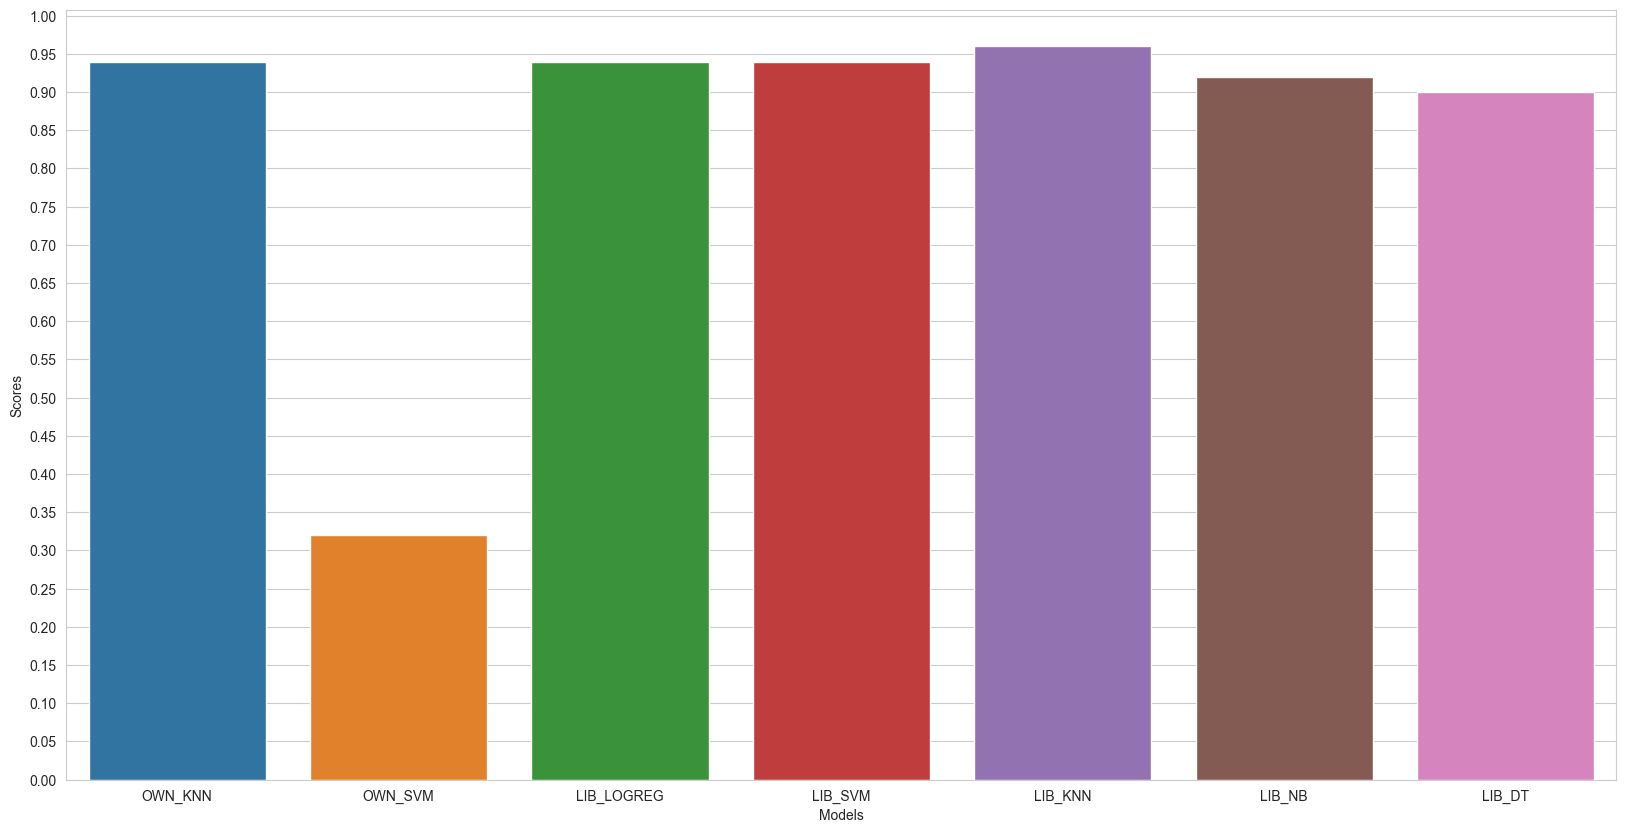

In [254]:
sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
plt.xlabel("Models")
plt.ylabel("Scores")
plt.yticks(np.arange(0, 1.05, 0.05))

sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.show()

### Построение Confusion Matrix для моделей

In [255]:
own_knn_cm = confusion_matrix(y_test, own_knn_y_test_pred)
own_svm_cm = confusion_matrix(y_test, own_svm_y_test_pred)
lib_logreg_cm = confusion_matrix(y_test, lib_logreg_y_test_pred)
lib_knn_cm = confusion_matrix(y_test, lib_knn_y_test_pred)
lib_svm_cm = confusion_matrix(y_test, lib_svm_y_test_pred)
lib_nb_cm = confusion_matrix(y_test, lib_nb_y_test_pred)
lib_dt_cm = confusion_matrix(y_test, lib_dt_y_test_pred)

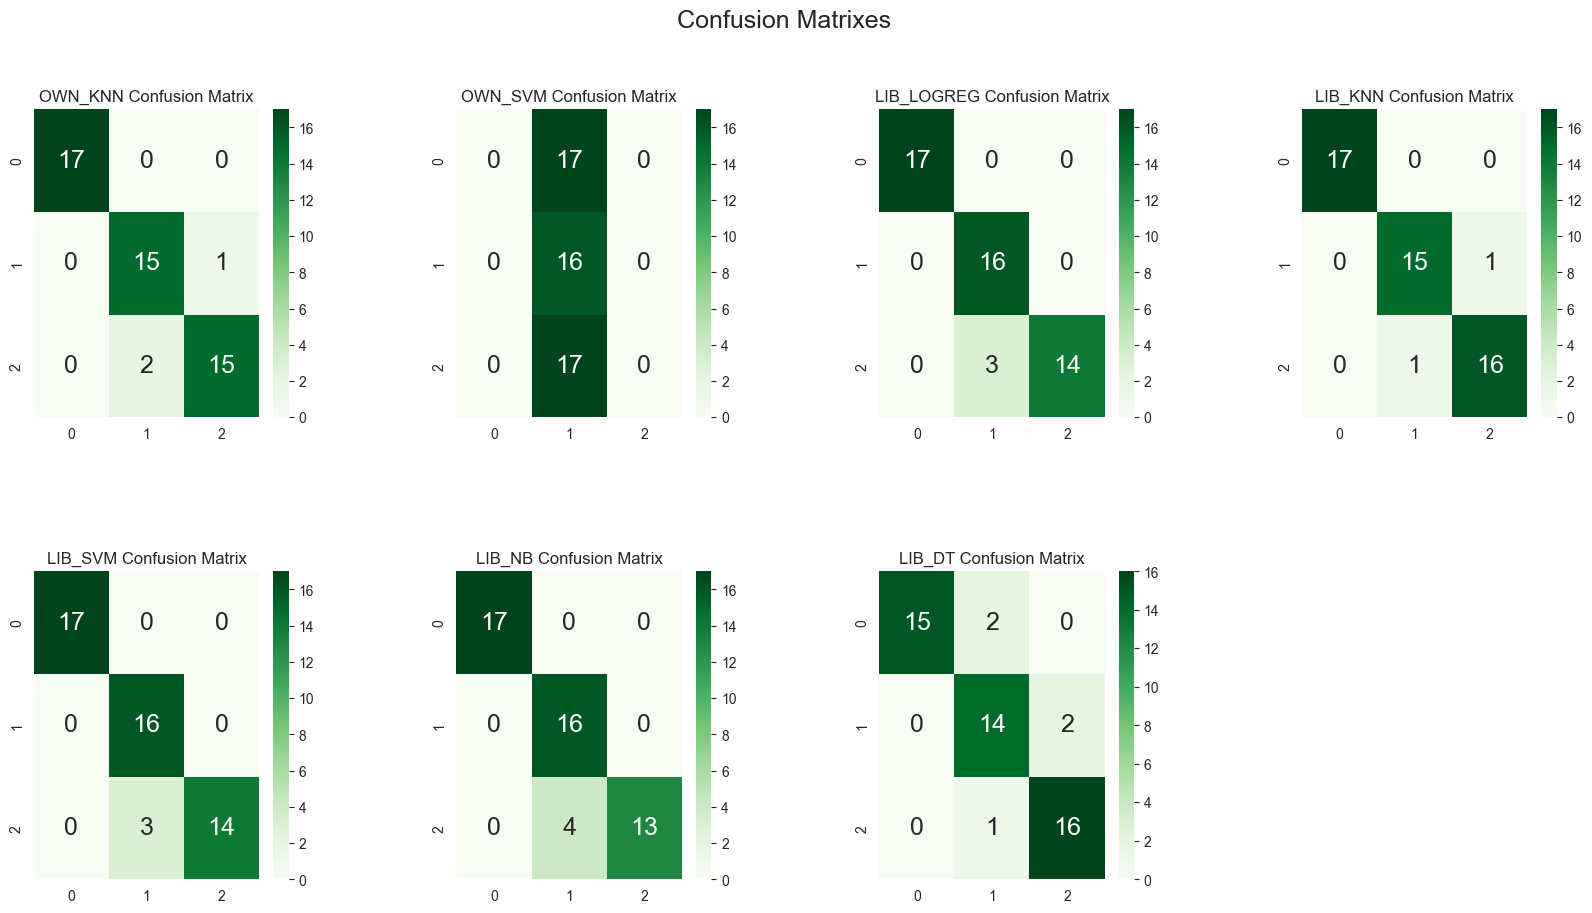

In [256]:
plt.figure(figsize=(20, 10))
plt.suptitle("Confusion Matrixes", fontsize=18)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.subplot(2, 4, 1)
plt.title("OWN_KNN Confusion Matrix")
sns.heatmap(own_knn_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 2)
plt.title("OWN_SVM Confusion Matrix")
sns.heatmap(own_svm_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 3)
plt.title("LIB_LOGREG Confusion Matrix")
sns.heatmap(lib_logreg_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 4)
plt.title("LIB_KNN Confusion Matrix")
sns.heatmap(lib_knn_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 5)
plt.title("LIB_SVM Confusion Matrix")
sns.heatmap(lib_svm_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 6)
plt.title("LIB_NB Confusion Matrix")
sns.heatmap(lib_nb_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 7)
plt.title("LIB_DT Confusion Matrix")
sns.heatmap(lib_dt_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})
plt.show()

## Выводы об обученных моделях второго датасета